## Fake News Prediction – 

Recently there has been a topic of fake news detection on social media, where lots of posts are getting published by many companies and daily basis and in order to identify if there is a fake news or not its not very easy, so with help of Machine learning, we will develop a solution which can identify if this is a fake news or not.

# Import Libraries

In [108]:
#from helper_functions import *
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [109]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AdyantSinha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/AdyantSinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/AdyantSinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Datasets

In [164]:
dftrain = pd.read_csv('./Data/train.csv')
dftest = pd.read_csv('./Data/test.csv')
dfsubmit = pd.read_csv('./Data/submit.csv')

# 1. Data Wrangling - 

Share and Dimension on datasets - 

In [165]:
print("Shape of train dataset - ", dftrain.shape)
print("Shape of test dataset - ", dftest.shape)

Shape of train dataset -  (20800, 5)
Shape of test dataset -  (5200, 4)


In [166]:
dftrain.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [167]:
dftest.head(2)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...


In [168]:
dftrain['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [169]:
print('Train Dataset')
print(dftrain.dtypes)
print()
print('Test Dataset')
print(dftest.dtypes)

Train Dataset
id         int64
title     object
author    object
text      object
label      int64
dtype: object

Test Dataset
id         int64
title     object
author    object
text      object
dtype: object


From the above results we can see that there are 10413 articles marked as legit news and 10387 articles are marked as Fake News.

### Drop the ID column -

In [170]:
dftrain.drop('id', axis=1, inplace=True)
dftest.drop('id', axis =1, inplace = True)

### Find the null values in datasets

In [171]:
dftrain.isna().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [172]:
dftest.isna().sum()

title     122
author    503
text        7
dtype: int64

In [173]:
# Percentage of missing value columns
dftrain.isna().sum()/len(dftrain)*100

title     2.682692
author    9.408654
text      0.187500
label     0.000000
dtype: float64

In [174]:
# Percentage of missing value columns
dftest.isna().sum()/len(dftest)*100

title     2.346154
author    9.673077
text      0.134615
dtype: float64

## Data PreProcessing

Below steps will be performing for the text - Data Preprocessing

1. Removing URLs from text
2. Making all text lowercase
3. Removing numbers from text
4. Removing punctuation from text
5. Tokenization - takes a string of text and turns it into a list of tokens (the words)
6. Removing stopwords - are words that typically add no meaning
7. Lemmatization - takes the tokens and breaks each down into its lemma. A lemma is essentially the base form of a word, cutting a way conjugation and declension

In [175]:
#Data Preprocessing - 
import string
def remove_urls(text):
    new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return new_text

# make all text lowercase
def text_lowercase(text):
    text=str(text)
    return text.lower()

# remove numbers
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# tokenize
def tokenize(text):
    text = word_tokenize(text)
    return text

# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [i for i in text if not i in stop_words]
    return text

# lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

def preprocessing(text):
    text = text_lowercase(text)
    text = remove_urls(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    text = ' '.join(text)
    return text

### Data Processing on Train Data

In [176]:
pre_train = [] # our preprocessed text column
for text_data in dftrain['text']:
    pre_data = preprocessing(text_data)
    pre_train.append(pre_data)
dftrain['processed_text'] = pre_train # add the preprocessed text as a column

In [177]:
dftrain.head(2)

,title,author,text,label,processed_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...


### Data Processing on Test Data

In [178]:
pre_test = [] # our preprocessed text column
for text_data in dftest['text']:
    pre_data = preprocessing(text_data)
    pre_test.append(pre_data)
dftest['processed_text'] = pre_test # add the preprocessed text as a column

In [179]:
dftest.head(2)

,title,author,text,processed_text
0,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",palo alto calif year scorning political proces...
1,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warship ready strike terrorist near al...


### Create a column with Length of Text Column

In [180]:
dftrain['textlen'] = dftrain["processed_text"].str.len()

In [181]:
dftrain.head(2)

,title,author,text,label,processed_text,textlen
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...,3168
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,2685


### Plot for Null Values in Train Dataset

author            1957
title              558
text                39
textlen              0
processed_text       0
label                0
dtype: int64


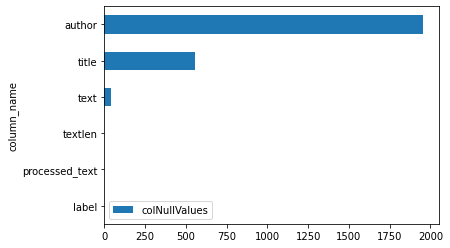

In [182]:
dfNull = pd.DataFrame(columns=['column_name', 'colNullValues'])
dfNull['column_name'] = dftrain.columns
dfNull['colNullValues'] = dftrain.isnull().sum().values
dfNull.sort_values(by=['colNullValues'], ascending=True, inplace=True)
dfNull.plot(x='column_name', y='colNullValues', kind='barh')
print(dftrain.isnull().sum().sort_values(ascending=False))
plt.show()

Three Attributes has the null values - Author, Title and Text. 

* Around 1957 records are null for Author

* Around 558 records are null for Title

* Around 39 records are null for Text

### Fill the Null values for Author and Title

In [183]:
values = {'author' : 'NA', 'title': 'NA'}
dftrain.fillna(value=values, inplace=True)

### Check Special Words in Text Columns

In [184]:
#dftrain.loc[dftrain['textlen'] == 0]
dftrain.loc[(dftrain['textlen'] == 0) & (dftrain['text'] != ' ')]

,title,author,text,label,processed_text,textlen
492,Казахстан на страже ядерной безопасности | Нов...,NA,В ноябре 2016 г. Мажилис Парламента Республики...,1,,0
650,Очередная автоколонна МЧС с гуманитарной помощ...,RT на русском,19 МЧС направило 57-ю по счёту автоколонну с ...,1,,0
710,СМИ: в России создадут систему для отслеживани...,RT на русском,Короткая ссылка 25 Совет РАН по космосу утвер...,1,,0
901,Internet Flasher,Groucho Marxist,,1,,0
1291,Положит ли Дональд Трамп конец «ваххабитскому ...,NA,Страна: Саудовская Аравия Как отмечает в своей...,1,,0
1645,О принцессах — ни слова!,Светлана Якн,Спорт \nВ Москве 30 октября прошли чемпионат м...,1,,0
1702,В России могут ввести налог на депозиты?,NA,0 комментариев \nОдним из вариантов пополнен...,1,,0
1763,Смогут ли выборы в Соединенных Штатах что-то и...,NA,Регион: США в мире В своей новой статье канадс...,1,,0
1852,Юный житель Стерлитамака спас жизнь выпавшей и...,NA,\nЮный житель поселка Строймаш Ярослав Адонь...,1,,0
1859,Стоит ли ожидать конца войны в Сирии? | Новое ...,NA,Страна: Сирия В своей новой статье постоянный ...,1,,0


There are 125 records where we have special words in the Text Column

### Additionally there are 39 records with NAN value

In [185]:
dftrain.loc[dftrain['text'].isna()]

,title,author,text,label,processed_text,textlen
142,Gorafi Magazine : Entretien exclusif avec Bara...,NA,NaN,1,nan,3
573,Le top des recherches Google passe en top des ...,NA,NaN,1,nan,3
1200,La Corée du Nord annonce avoir envoyé un missi...,NA,NaN,1,nan,3
1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NA,NaN,1,nan,3
2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NA,NaN,1,nan,3
2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NA,NaN,1,nan,3
2793,«Pourquoi je suis candidat à la présidentielle...,NA,NaN,1,nan,3
3329,GuinessBook : 100 millions d’Américains batten...,NA,NaN,1,nan,3
3729,Les Américains ne sont plus qu’à quelques heur...,NA,NaN,1,nan,3
4288,Hillary Clinton en 5 dates >> Le Gorafi,NA,NaN,1,nan,3


### Handling the NAN Values and Special Characters for Text Column in Train Dataset

In [186]:
dftrain.drop(dftrain.loc[(dftrain['textlen'] == 0)].index, inplace=True)

In [191]:
dftrain.dropna(inplace=True)

In [193]:
print(dftrain.shape)
dftrain.head(2)

(20636, 6)


,title,author,text,label,processed_text,textlen
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...,3168
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,2685


textlen           0
processed_text    0
label             0
text              0
author            0
title             0
dtype: int64


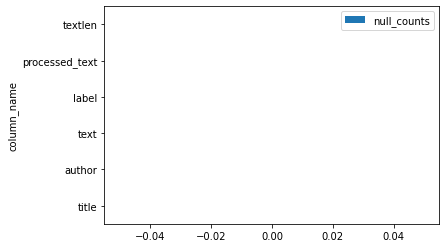

In [198]:
null_df = pd.DataFrame(columns=['column_name', 'null_counts'])
null_df['column_name'] = dftrain.columns
null_df['null_counts'] = dftrain.isnull().sum().values
null_df.sort_values(by=['null_counts'], ascending=True, inplace=True)
null_df.plot(x='column_name', y='null_counts', kind='barh')
print(dftrain.isnull().sum().sort_values(ascending=False))
plt.show()

In [197]:
dftrain.isna().sum()

title             0
author            0
text              0
label             0
processed_text    0
textlen           0
dtype: int64

### Create Length in Test Dataset

In [206]:
dftest['textlen'] = dftest["processed_text"].str.len()

### Handle the Null values in Test Dataset for Author and Title

In [207]:
values = {'author' : 'NA', 'title': 'NA'}
dftest.fillna(value=values, inplace=True)

### Explore the data in Test Dataset

In [208]:
dftest.loc[(dftrain['textlen'] == 0) & (dftest['text'] != ' ')]

,title,author,text,processed_text,textlen


In [209]:
dftest.loc[dftest['text'].isna()]

,title,author,text,processed_text,textlen
589,[Vidéo] Que trouve-t-on dans « Le Gorafi de l’...,NA,NaN,nan,3
626,Nous avons comparé les programmes d’Alain Jupp...,NA,NaN,nan,3
978,« J’y crois encore ! » par Alain Juppé en trai...,NA,NaN,nan,3
2257,Horoscope du 14 novembre 2016 >> Le Gorafi,NA,NaN,nan,3
2892,Une fan demande le remboursement de son tatoua...,NA,NaN,nan,3
4736,Révélations – François Fillon serait de droite...,NA,NaN,nan,3
5092,Des traces de vin rouge détectées dans le Beau...,NA,NaN,nan,3


### Handle the NAN and Special Characters in Test Dataset

In [210]:
dftest.drop(dftest.loc[(dftest['textlen'] == 0)].index, inplace=True)

In [211]:
dftest.dropna(inplace=True)

In [212]:
print(dftest.shape)
dftrain.head(2)

(5146, 5)


,title,author,text,label,processed_text,textlen
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...,3168
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,2685


### Create the Corpus of Words as below from Train and Test Datasets

In [199]:
train_text_data = list(dftrain['processed_text'])
test_text_data = list(dftest['processed_text'])
corpus = train_text_data + test_text_data

In [200]:
corpus

['house dem aide even see comey letter jason chaffetz tweeted darrell lucus october subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative common license apology keith olbermann doubt worst person world week fbi director james comey according house democratic aide look like also know second worst person well turn comey sent infamous letter announcing fbi looking email may related hillary clinton email server ranking democrat relevant committee hear comey found via tweet one republican committee chairman know comey notified republican chairman democratic ranking member house intelligence judiciary oversight committee agency reviewing email recently discovered order see contained classified information long letter went oversight committee chairman jason chaffetz set political world ablaze tweet fbi dir informed fbi learned existence email appear pertinent investigation case reopened jason chaffetz october course know case comey actually saying 

# 2. Data Visualization

### Create the Sentiments Analysis

In [213]:
dftrain['sentiment'] = dftrain['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
dftrain.head()

,title,author,text,label,processed_text,textlen,sentiment
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...,3168,0.006115
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,2685,0.077613
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...,5087,0.076293
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video civilian killed single u airstrike ident...,2155,0.020509
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six year prison ...,653,0.047143


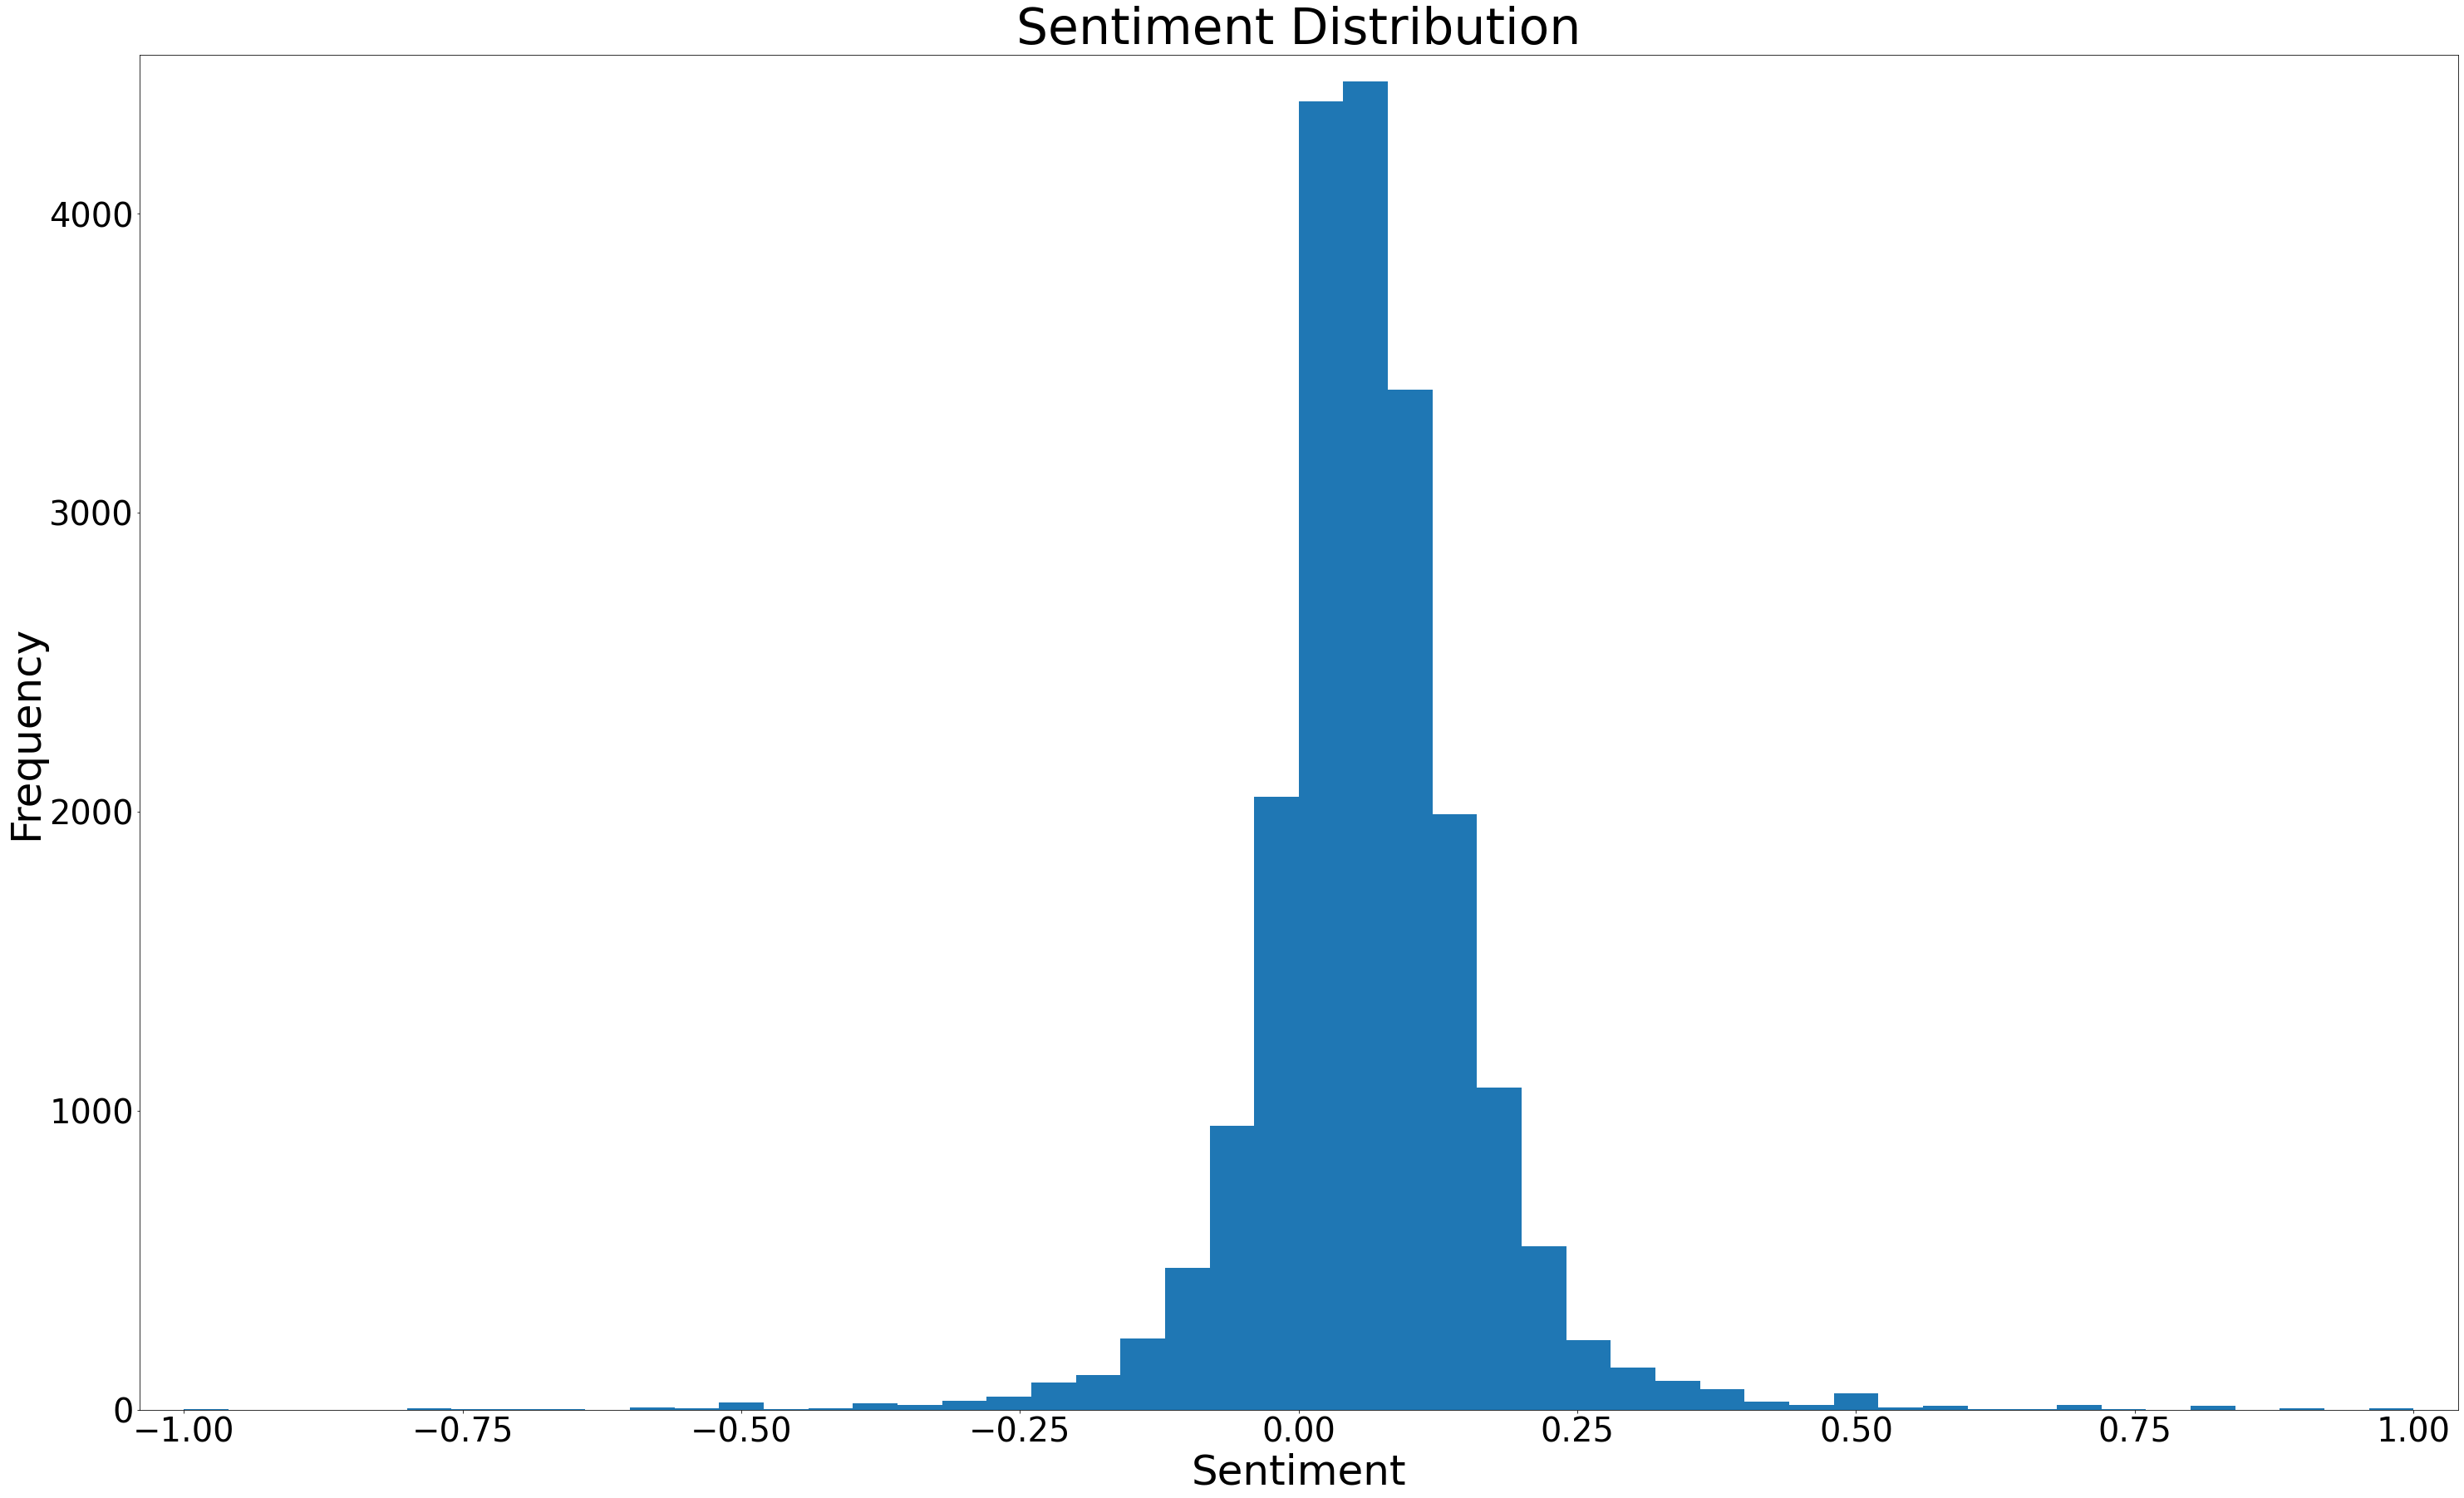

In [214]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(dftrain['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

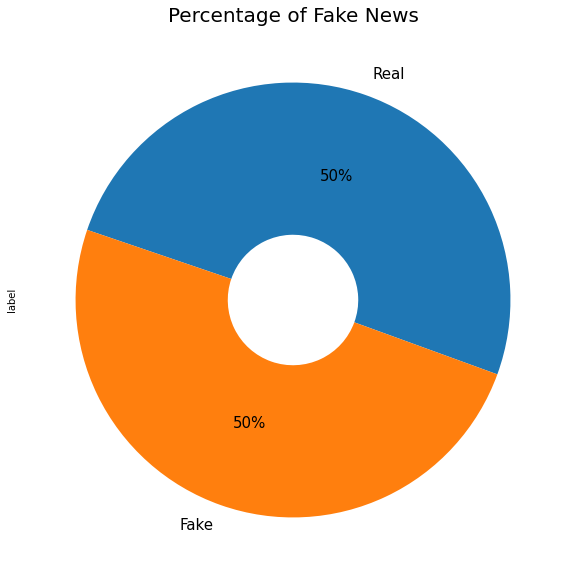

In [215]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Fake News', fontsize=20)
dftrain.label.value_counts().plot(kind='pie', labels=['Real', 'Fake'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

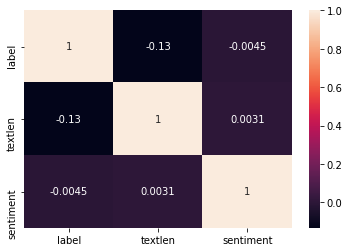

In [217]:
# Create a heatmap 
corr = dftrain.corr()
sns.heatmap(corr, annot=True)
plt.show()

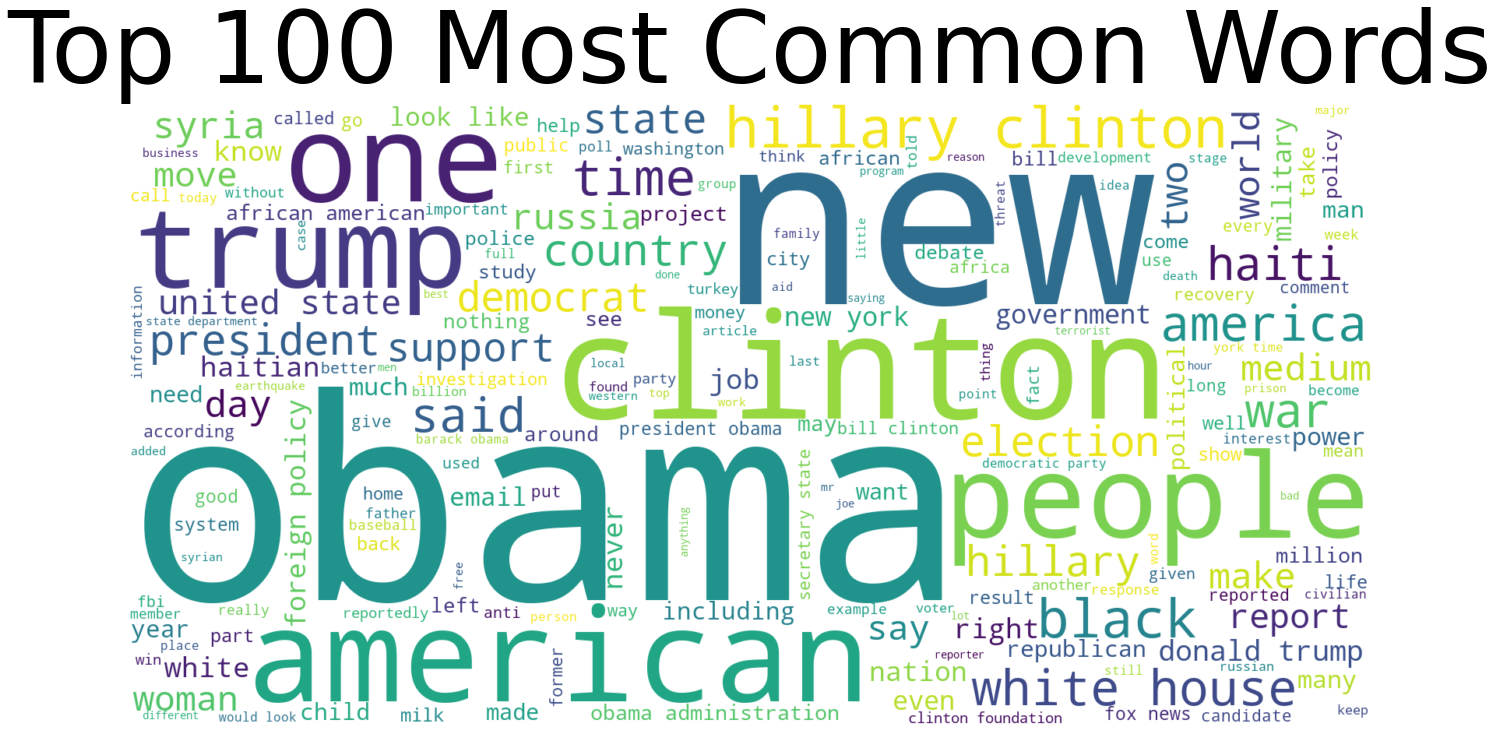

In [221]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

mostcommon = FreqDist(corpus).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()